In [1]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
import pkg_resources
import yaml

In [2]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [3]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=False, exclude_outliers=True)]
sessions = [1]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr', 'NPC12r']
n_voxels = [1, 100]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

pred = pd.concat(pred)


df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')

r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

  0%|          | 0/292 [00:00<?, ?it/s]

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_10580/2651301265.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [4]:
import arviz as az
idata = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-everyone_trace.netcdf')

In [5]:
n1_evidence_sd = idata.posterior['n1_evidence_sd'].to_dataframe()
n2_evidence_sd = idata.posterior['n2_evidence_sd'].to_dataframe()

In [6]:
import seaborn as sns
import arviz as az

def get_ci(x):
    return az.hdi(x.values.ravel())

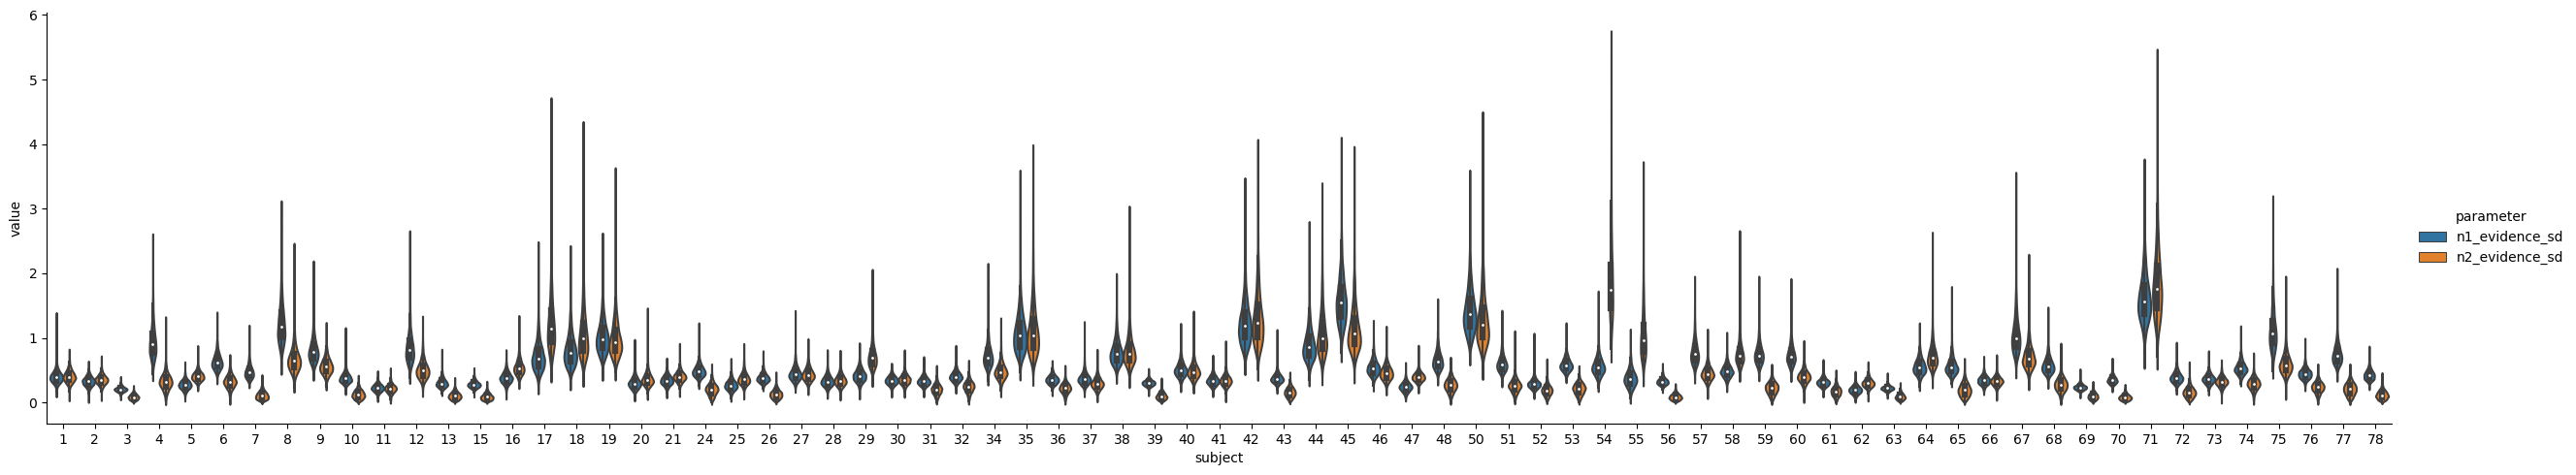

In [7]:
evidence_sd = pd.concat((n1_evidence_sd, n2_evidence_sd), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')

# Make sure that the markers do not get connected
sns.catplot(x='subject', y='value', hue='parameter', data=evidence_sd.reset_index(), kind='violin', errorbar=get_ci, aspect=5, )

In [8]:
mean_evidence_sd = evidence_sd.groupby(['subject', 'parameter']).mean()
pingouin.corr(*mean_evidence_sd.unstack('parameter').values.T)

,n,r,CI95%,p-val,BF10,power
pearson,73,0.688468,"[0.54, 0.79]",1.682142e-11,6.357e+08,1.0


In [10]:
def plot_scatter_with_errors(data, xlabel='Vertex', ylabel='IPS', **kwargs):

    x = data[('mean', xlabel)]
    y = data[('mean', ylabel)] 

    xerr_min = x - data['ci_min', xlabel]
    xerr_max = data['ci_max', xlabel] - x

    yerr_min = y - data['ci_min', ylabel]
    yerr_max = data['ci_max', ylabel] - y


    plt.errorbar(x, y, [yerr_min, yerr_max], [xerr_min, xerr_max], fmt='.', markersize=0, alpha=0.5, **kwargs)
    plt.scatter(data[('mean', xlabel)], data[('mean', ylabel)], marker='.', s=50, **kwargs)


def plot_identity_line(*args, **kwargs):

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x0 = (xlim[0] + ylim[0]) / 2.
    x1 = (xlim[1] + ylim[1]) / 2.

    plt.plot([x0, x1], [x0, x1], c='k', ls='--')

In [11]:
mean_pars = evidence_sd.groupby(['subject', 'parameter'])['value'].mean().to_frame('mean')
ci_pars = evidence_sd.groupby(['subject', 'parameter'])['value'].apply(lambda x: pd.Series(az.hdi(x.values.ravel(), .95), index=pd.Index(['ci_min', 'ci_max']))).to_frame('value').unstack(-1)['value']

par_stats = mean_pars.join(ci_pars)

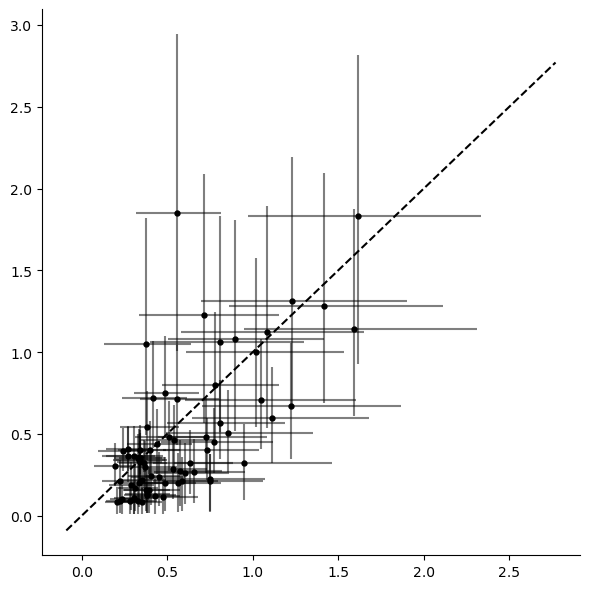

In [12]:
g = sns.FacetGrid(par_stats.unstack(['parameter']).reset_index(), height=6)

g.map_dataframe(plot_scatter_with_errors, color='k', xlabel='n1_evidence_sd', ylabel='n2_evidence_sd')
g.map(plot_identity_line)
# g.set_titles('{col_name}')
# g.set(xlabel='Vertex', ylabel='IPS')
# g.set_xlabels('n1j')
# g.set_ylabels('IPS')

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73 -0.046336  [-0.27, 0.19]  0.697079  0.157   
       100      pearson  73 -0.101189  [-0.32, 0.13]  0.394309  0.209   
NPCr   1        pearson  73 -0.064007  [-0.29, 0.17]  0.590585  0.168   
       100      pearson  73 -0.227432   [-0.43, 0.0]  0.052980  0.916   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.067395  
       100      pearson  0.136693  
NPCr   1        pearson  0.083713  
       100      pearson  0.495295

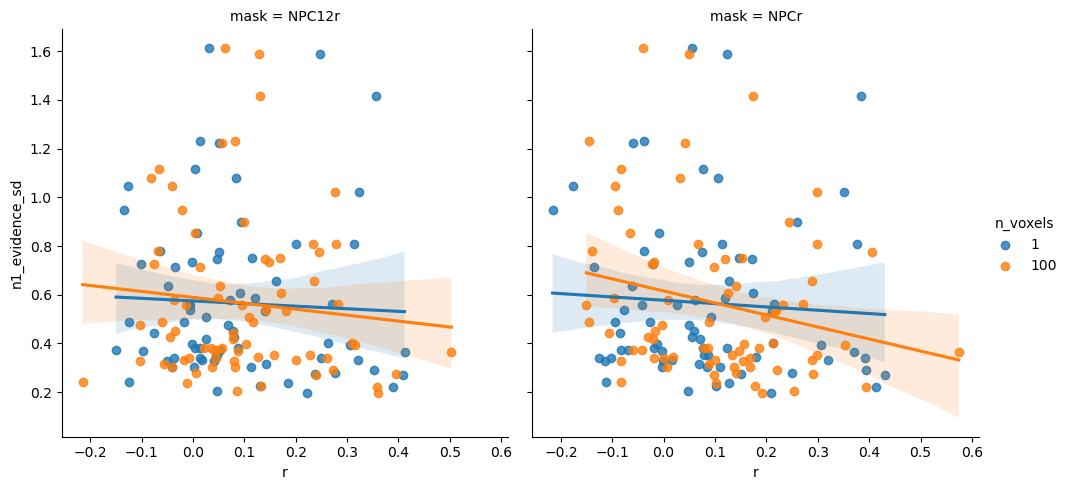

In [13]:
n1_evidence_sd_mean = n1_evidence_sd.groupby(['subject']).mean()
tmp = r2.join(n1_evidence_sd_mean)
tmp['log(n1_evidence_sd)'] = np.log(tmp['n1_evidence_sd'])

sns.lmplot(x='r', y='n1_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['n1_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n1_evidence_sd']))

In [14]:
pingouin.corr(tmp['r'], tmp['log(n1_evidence_sd)'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['log(n1_evidence_sd)']))

n         r           CI95%     p-val   BF10  \
mask   n_voxels                                                          
NPC12r 1        pearson  73 -0.127038   [-0.35, 0.11]  0.284160  0.257   
       100      pearson  73 -0.121343   [-0.34, 0.11]  0.306477  0.244   
NPCr   1        pearson  73 -0.119319   [-0.34, 0.11]  0.314673   0.24   
       100      pearson  73 -0.241141  [-0.45, -0.01]  0.039862  1.159   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.189055  
       100      pearson  0.176416  
NPCr   1        pearson  0.172075  
       100      pearson  0.543919

In [15]:
n1_evidence_sd_mean

,n1_evidence_sd
subject,
1,0.398891
2,0.327970
3,0.205610
4,0.947048
5,0.272999
...,...
74,0.534770
75,1.115166
76,0.449691


n         r           CI95%     p-val   BF10  \
mask   n_voxels                                                          
NPC12r 1        pearson  73 -0.051840   [-0.28, 0.18]  0.663150   0.16   
       100      pearson  73 -0.095039   [-0.32, 0.14]  0.423821    0.2   
NPCr   1        pearson  73 -0.078596    [-0.3, 0.15]  0.508640  0.181   
       100      pearson  73 -0.275925  [-0.48, -0.05]  0.018133  2.256   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.071888  
       100      pearson  0.126127  
NPCr   1        pearson  0.101417  
       100      pearson  0.664291

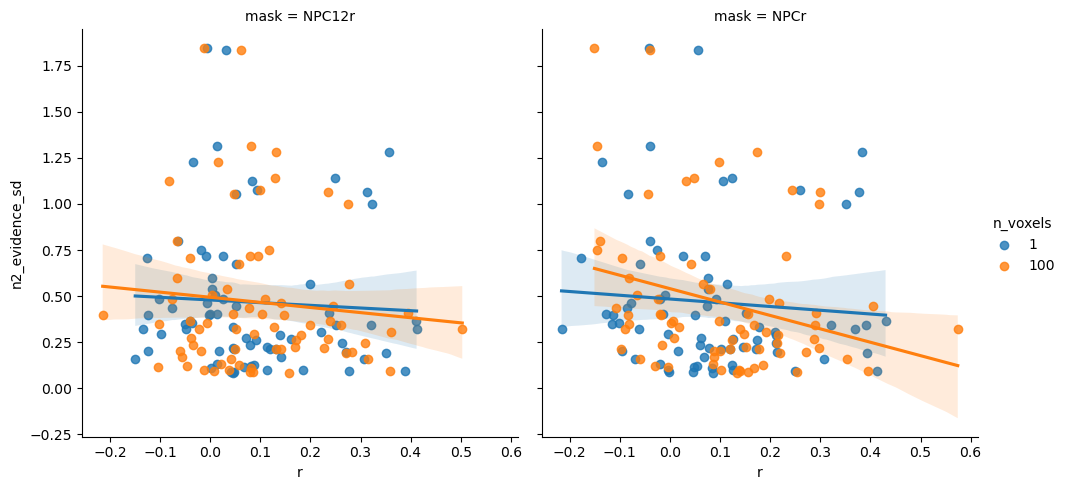

In [16]:
n2_evidence_sd_mean = n2_evidence_sd.groupby(['subject']).mean()
tmp = r2.join(n2_evidence_sd_mean)
tmp['log(n2_evidence_sd)'] = np.log(tmp['n2_evidence_sd'])

sns.lmplot(x='r', y='n2_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['n2_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n2_evidence_sd']))

In [17]:
pingouin.corr(tmp['r'], tmp['log(n2_evidence_sd)'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['log(n2_evidence_sd)']))

n         r           CI95%     p-val   BF10  \
mask   n_voxels                                                          
NPC12r 1        pearson  73 -0.108490   [-0.33, 0.12]  0.360908   0.22   
       100      pearson  73 -0.051642   [-0.28, 0.18]  0.664360   0.16   
NPCr   1        pearson  73 -0.112818   [-0.33, 0.12]  0.341951  0.228   
       100      pearson  73 -0.278638  [-0.48, -0.05]  0.016983  2.387   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.150178  
       100      pearson  0.071717  
NPCr   1        pearson  0.158658  
       100      pearson  0.673265

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_10580/1452569080.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]


n         r           CI95%         p-val  \
mask   n_voxels                                                       
NPC12r 1        pearson  73 -0.494529   [-0.65, -0.3]  8.708064e-06   
       100      pearson  73 -0.059960   [-0.29, 0.17]  6.143263e-01   
NPCr   1        pearson  73 -0.539639  [-0.68, -0.35]  8.367269e-07   
       100      pearson  73 -0.063028   [-0.29, 0.17]  5.962896e-01   

                              BF10     power  
mask   n_voxels                               
NPC12r 1        pearson   2362.903  0.995365  
       100      pearson      0.166  0.079487  
NPCr   1        pearson  2.137e+04  0.999096  
       100      pearson      0.168  0.082664

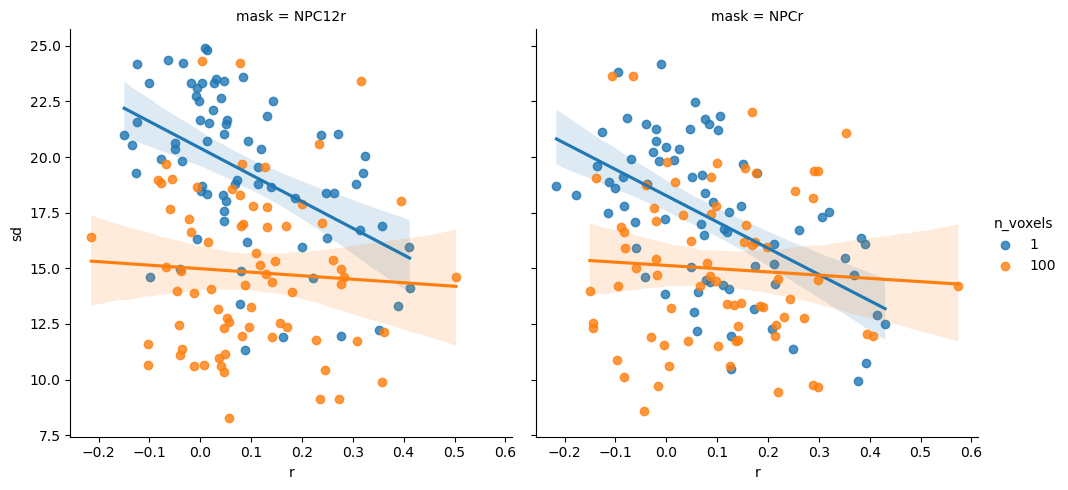

In [18]:
mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]

mean_sd = mean_sd.join(r2)

sns.lmplot(x='r', y='sd', data=mean_sd.reset_index(), hue='n_voxels', col='mask')

mean_sd.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['sd']))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_10580/1617616272.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]


n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.198424  [-0.03, 0.41]  0.092404  0.586   
       100      pearson  73  0.120323  [-0.11, 0.34]  0.310588  0.242   
NPCr   1        pearson  73  0.187209   [-0.04, 0.4]  0.112748  0.502   
       100      pearson  73  0.054492  [-0.18, 0.28]  0.647037  0.162   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.394538  
       100      pearson  0.174220  
NPCr   1        pearson  0.357386  
       100      pearson  0.074242

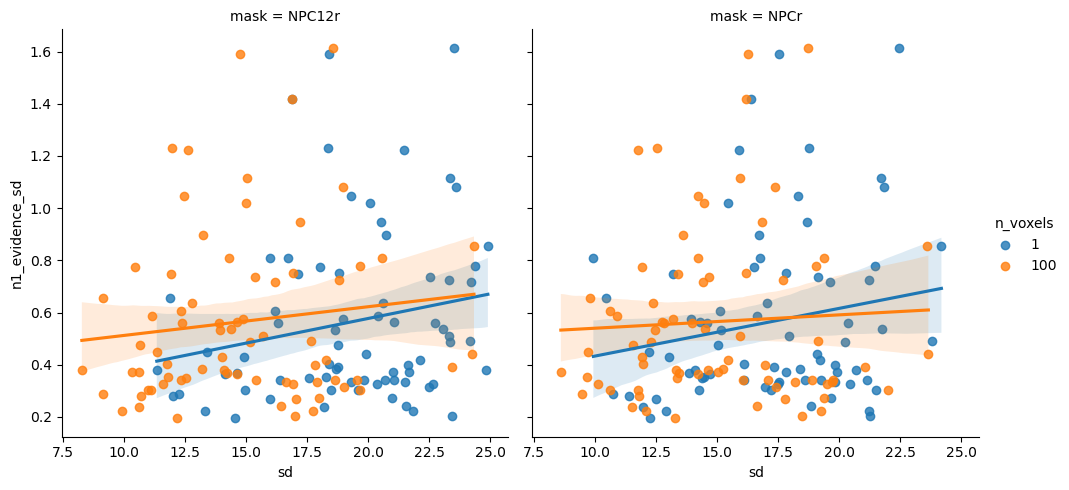

In [19]:
mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]

mean_sd = mean_sd.join(n1_evidence_sd_mean)

sns.lmplot(x='sd', y='n1_evidence_sd', data=mean_sd.reset_index(), hue='n_voxels', col='mask')

mean_sd.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['n1_evidence_sd']))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_10580/1746772962.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]


n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.217509  [-0.01, 0.43]  0.064527   0.78   
       100      pearson  73  0.167216  [-0.07, 0.38]  0.157358   0.39   
NPCr   1        pearson  73  0.191797   [-0.04, 0.4]  0.104043  0.534   
       100      pearson  73  0.071830   [-0.16, 0.3]  0.545905  0.175   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.460304  
       100      pearson  0.295019  
NPCr   1        pearson  0.372422  
       100      pearson  0.092721

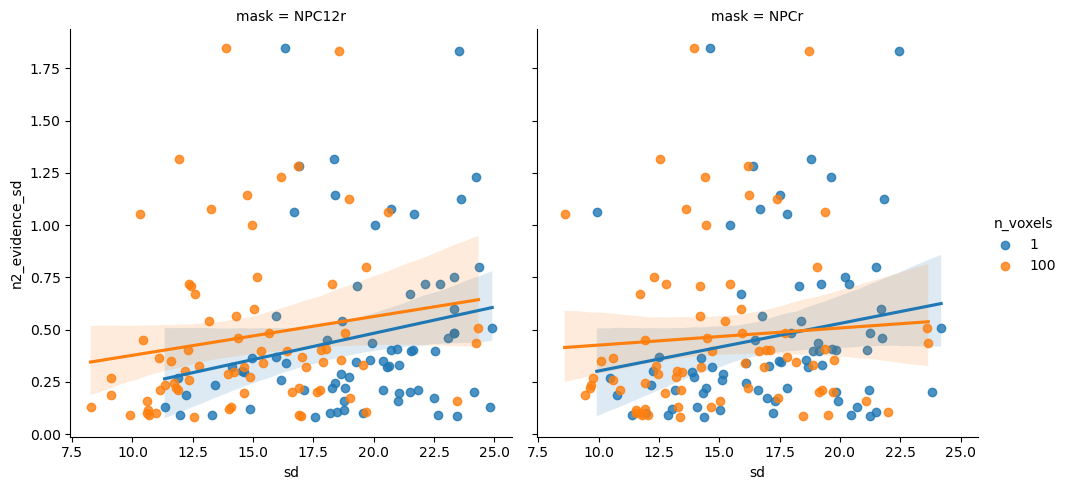

In [20]:
mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]

mean_sd = mean_sd.join(n2_evidence_sd_mean)

sns.lmplot(x='sd', y='n2_evidence_sd', data=mean_sd.reset_index(), hue='n_voxels', col='mask')

mean_sd.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['n2_evidence_sd']))

In [21]:
sum_evidence_sd = np.sqrt(n1_evidence_sd['n1_evidence_sd']**2 + n2_evidence_sd['n2_evidence_sd']**2)


mean_sum_evidence_sd = sum_evidence_sd.groupby(['subject']).mean().to_frame('mean_evidence_sd')

n         r           CI95%     p-val   BF10  \
mask   n_voxels                                                          
NPC12r 1        pearson  73 -0.062777   [-0.29, 0.17]  0.597755  0.168   
       100      pearson  73 -0.117155   [-0.34, 0.12]  0.323591  0.236   
NPCr   1        pearson  73 -0.091479   [-0.31, 0.14]  0.441467  0.195   
       100      pearson  73 -0.289371  [-0.49, -0.06]  0.013025  3.002   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.082398  
       100      pearson  0.167520  
NPCr   1        pearson  0.120342  
       100      pearson  0.707893

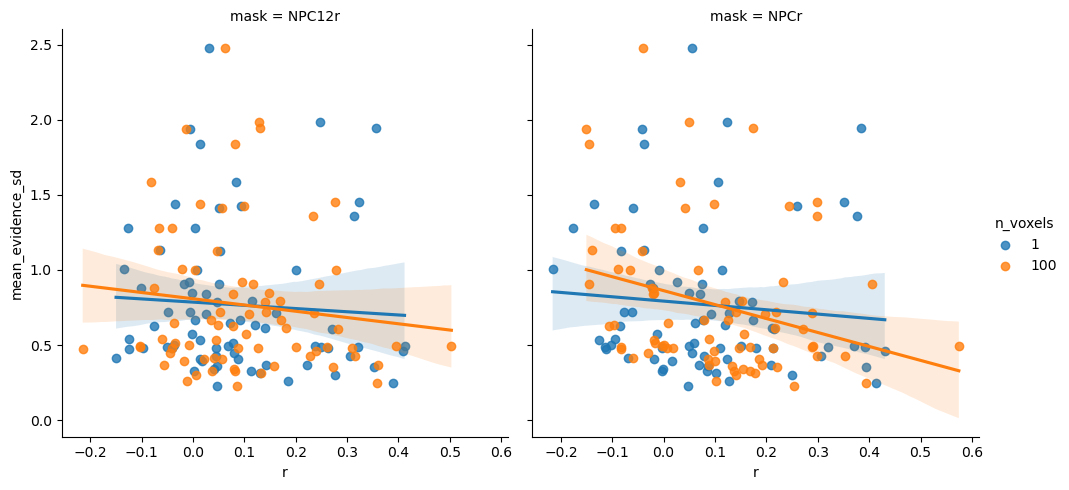

In [22]:
tmp = r2.join(mean_sum_evidence_sd)
tmp['log(mean_evidence_sd)'] = np.log(tmp['mean_evidence_sd'])

sns.lmplot(x='r', y='mean_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['mean_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['mean_evidence_sd']))

# Only TMS subjects

In [25]:
tms_ids = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True)]

In [26]:
mean_n1_evidence_sd = n1_evidence_sd.loc[slice(None), slice(None), tms_ids].groupby(['subject']).mean()
mean_n2_evidence_sd = n2_evidence_sd.loc[slice(None), slice(None), tms_ids].groupby(['subject']).mean()

In [27]:
r2_tms = r2.loc[tms_ids]

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  35  0.142121   [-0.2, 0.45]  0.415410  0.289   
       100      pearson  35 -0.057079  [-0.38, 0.28]  0.744663  0.221   
NPCr   1        pearson  35  0.105780  [-0.24, 0.42]  0.545329  0.251   
       100      pearson  35 -0.178008  [-0.48, 0.17]  0.306277  0.348   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.129297  
       100      pearson  0.061902  
NPCr   1        pearson  0.092852  
       100      pearson  0.177253

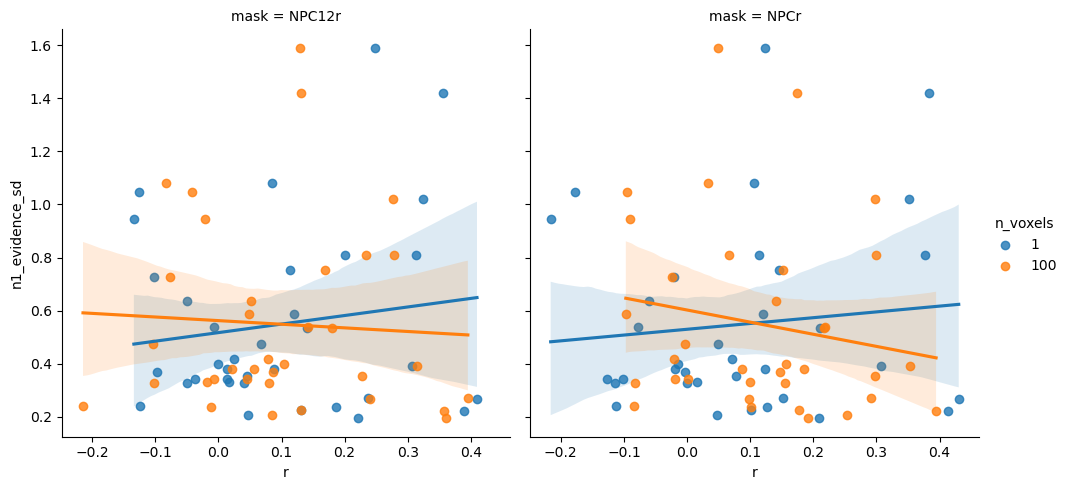

In [28]:
tmp = r2_tms.join(mean_n1_evidence_sd)

tmp['log(n1_evidence_sd)'] = np.log(tmp['n1_evidence_sd'])

sns.lmplot(x='r', y='n1_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['n1_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n1_evidence_sd']))

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  35  0.263707  [-0.08, 0.55]  0.125845  0.648   
       100      pearson  35  0.040331   [-0.3, 0.37]  0.818069  0.216   
NPCr   1        pearson  35  0.248838  [-0.09, 0.54]  0.149453  0.571   
       100      pearson  35 -0.076910   [-0.4, 0.26]  0.660566  0.231   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.339665  
       100      pearson  0.055691  
NPCr   1        pearson  0.307002  
       100      pearson  0.072136

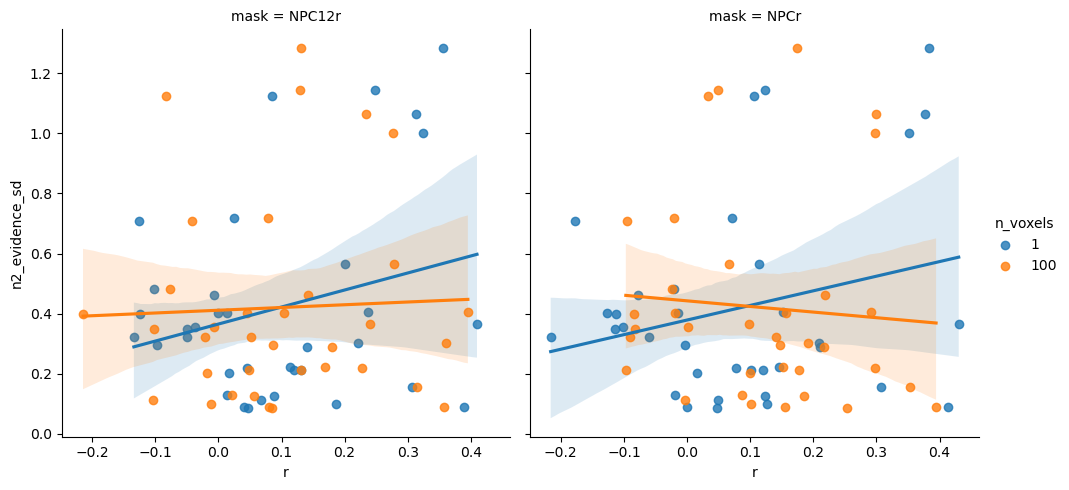

In [29]:
tmp = r2_tms.join(mean_n2_evidence_sd)

tmp['log(n2_evidence_sd)'] = np.log(tmp['n2_evidence_sd'])

sns.lmplot(x='r', y='n2_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['n2_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n2_evidence_sd']))

In [30]:
mean_sum_evidence_sd = np.sqrt(mean_n1_evidence_sd['n1_evidence_sd']**2 + mean_n2_evidence_sd['n2_evidence_sd']**2).to_frame('mean_evidence_sd')

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  35  0.202747   [-0.14, 0.5]  0.242772  0.405   
       100      pearson  35 -0.019388  [-0.35, 0.32]  0.911978  0.212   
NPCr   1        pearson  35  0.175828  [-0.17, 0.48]  0.312335  0.344   
       100      pearson  35 -0.149051  [-0.46, 0.19]  0.392794  0.299   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.217390  
       100      pearson  0.050969  
NPCr   1        pearson  0.173993  
       100      pearson  0.137615

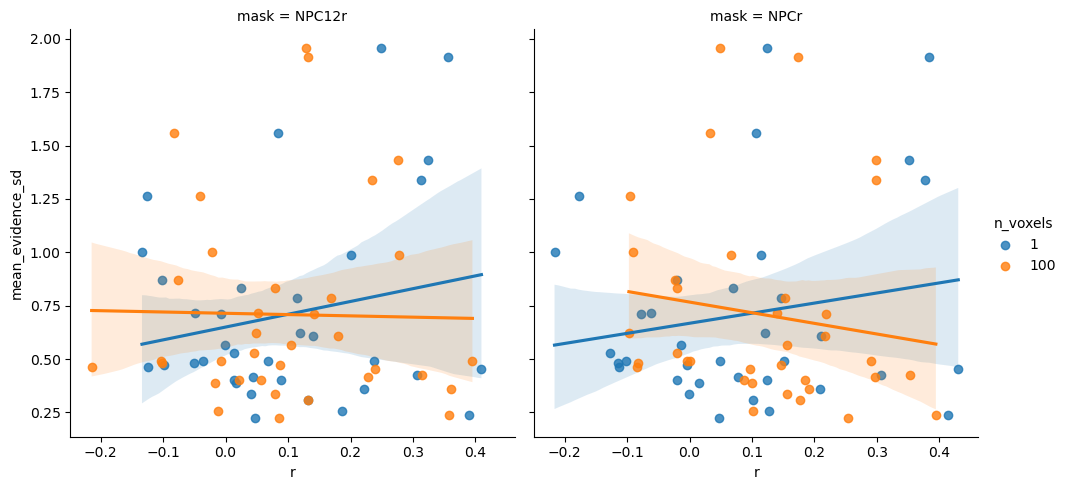

In [31]:
tmp = r2.join(mean_sum_evidence_sd)
tmp['log(mean_evidence_sd)'] = np.log(tmp['mean_evidence_sd'])

sns.lmplot(x='r', y='mean_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['mean_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['mean_evidence_sd']))

In [32]:
df.groupby(['subject']).size()

subject
1     360
2     360
3     360
4     360
5     360
     ... 
74    360
75    120
76    120
77    120
78    120
Length: 73, dtype: int64